### Imports

In [9]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

### Decision tree

In [2]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.depth = 0
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)
    
    def get_depth(self):
        return self.depth

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if self.max_depth is not None and depth >= self.max_depth or num_samples < self.min_samples_split or num_labels == 1:
            return {'leaf': True, 'value': self._most_common_label(y)}

        best_split = self._find_best_split(X, y)
        if not best_split:
            return {'leaf': True, 'value': self._most_common_label(y)}

        left_tree = self._build_tree(X[best_split['left_idx']], y[best_split['left_idx']], depth + 1)
        right_tree = self._build_tree(X[best_split['right_idx']], y[best_split['right_idx']], depth + 1)
        self.depth += 1
        return {'leaf': False, 'feature': best_split['feature'], 'threshold': best_split['threshold'],
                'left': left_tree, 'right': right_tree}

    def _find_best_split(self, X, y):
        best_gain = -float('inf')
        best_split = None
        num_samples, num_features = X.shape

        for feature_idx in range(num_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_idx = np.where(X[:, feature_idx] <= threshold)[0]
                right_idx = np.where(X[:, feature_idx] > threshold)[0]

                if len(left_idx) < self.min_samples_leaf or len(right_idx) < self.min_samples_leaf:
                    continue

                gain = self._information_gain(y, y[left_idx], y[right_idx])
                if gain > best_gain:
                    best_gain = gain
                    best_split = {'feature': feature_idx, 'threshold': threshold,
                                  'left_idx': left_idx, 'right_idx': right_idx}
        return best_split

    def _information_gain(self, parent_labels, left_labels, right_labels):
        if self.criterion == 'gini':
            return self._gini_impurity(parent_labels) - (
                    len(left_labels) / len(parent_labels) * self._gini_impurity(left_labels) +
                    len(right_labels) / len(parent_labels) * self._gini_impurity(right_labels))
        elif self.criterion == 'entropy':
            return self._entropy(parent_labels) - (
                    len(left_labels) / len(parent_labels) * self._entropy(left_labels) +
                    len(right_labels) / len(parent_labels) * self._entropy(right_labels))

    def _gini_impurity(self, labels):
        _, counts = np.unique(labels, return_counts=True)
        probs = counts / counts.sum()
        return 1 - np.sum(probs ** 2)

    def _entropy(self, labels):
        _, counts = np.unique(labels, return_counts=True)
        probs = counts / counts.sum()
        return -np.sum(probs * np.log2(probs + 1e-9))

    def _most_common_label(self, y):
        y = y.astype(int)
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _traverse_tree(self, x, tree):
        if tree['leaf']:
            return tree['value']
        if x[tree['feature']] <= tree['threshold']:
            return self._traverse_tree(x, tree['left'])
        else:
            return self._traverse_tree(x, tree['right'])


### Случайный лес

In [3]:
class RandomForest:
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None,
                 criterion='gini'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.criterion = criterion
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            indices = np.random.choice(len(X), len(X), replace=True)
            bootstrap_X, bootstrap_y = X[indices], y[indices]
            tree = DecisionTree(max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split,
                                min_samples_leaf=self.min_samples_leaf,
                                criterion=self.criterion)

            if self.max_features:
                feature_indices = np.random.choice(X.shape[1], self.max_features, replace=False)
                tree.fit(bootstrap_X[:, feature_indices], bootstrap_y)
                tree.feature_indices = feature_indices
            else:
                tree.fit(bootstrap_X, bootstrap_y)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X[:, tree.feature_indices]) if hasattr(tree, 'feature_indices')
                               else tree.predict(X) for tree in self.trees])
        return np.squeeze(np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_preds))


### Boosting

In [4]:
class GradientBoosting:
    def __init__(self, base_learner, T, loss_function, learning_rate):
        self.base_learner = base_learner
        self.T = T
        self.loss_function = loss_function
        self.learning_rate = learning_rate
        self.models = []
        self.coefficients = []

    def fit(self, X, y):
        H = np.zeros_like(y, float)

        for t in tqdm(range(self.T)):
            gradient = -self.loss_function.gradient(y, H)

            learner = self.base_learner()
            learner.fit(X, gradient)

            predictions = learner.predict(X)
            b_t = self._line_search(y, H, predictions)

            H += self.learning_rate * b_t * predictions
            self.models.append(learner)
            self.coefficients.append(b_t)

    def _line_search(self, y, H, predictions):
        numerator = np.sum((y - H) * predictions)
        denominator = np.sum(predictions ** 2)
        return numerator / (denominator + 1e-9)

    def predict(self, X):
        H = np.zeros(X.shape[0])
        for learner, b_t in zip(self.models, self.coefficients):
            H += self.learning_rate * b_t * learner.predict(X)
        return H


class QuadraticLoss:
    @staticmethod
    def loss(y, y_pred):
        return np.mean((y - y_pred) ** 2)

    @staticmethod
    def gradient(y, y_pred):
        return y_pred - y

### My dataset

In [5]:
phones = pd.read_csv('expensive_dataset.csv')
phones.columns.tolist()
phones.drop(columns=['model', 'release_date', 'main_camera'], inplace=True)
phones.drop(phones.columns[0], axis=1, inplace=True)
X = phones.drop(columns='expensive')
y = phones['expensive']


def get_split_data(train_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=1234)
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = np.where(y_train == 0, 0, 1)
    y_test = np.where(y_test == 0, 0, 1)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_split_data(0.8)

In [6]:
def plot_depth_vs_hyperparams(tree_model, X=X_train, y=y_train, max_split_values = 100, max_leaf_values = 100):  
    min_samples_split_values = range(2, max_split_values + 1)
    min_samples_leaf_values = range(1, max_leaf_values + 1)
    
    depths_split = []
    depths_leaf = []
    
    for min_samples_split in tqdm(min_samples_split_values, "Split hyperparam:"):
        tree = tree_model(max_depth=None, min_samples_split=min_samples_split)
        tree.fit(X, y)
        depths_split.append(tree.get_depth())
    
    for min_samples_leaf in tqdm(min_samples_leaf_values, "Leaf hyperparam:"):
        tree = tree_model(max_depth=None, min_samples_leaf=min_samples_leaf)
        tree.fit(X, y)
        depths_leaf.append(tree.get_depth())
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(min_samples_split_values, depths_split, marker='o', label='Tree Depth')
    plt.title('Tree Depth vs min_samples_split')
    plt.xlabel('min_samples_split')
    plt.ylabel('Tree Depth')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(min_samples_leaf_values, depths_leaf, marker='o', label='Tree Depth')
    plt.title('Tree Depth vs min_samples_leaf')
    plt.xlabel('min_samples_leaf')
    plt.ylabel('Tree Depth')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Leaf hyperparam:: 100%|██████████| 100/100 [00:00<00:00, 266.21it/s]


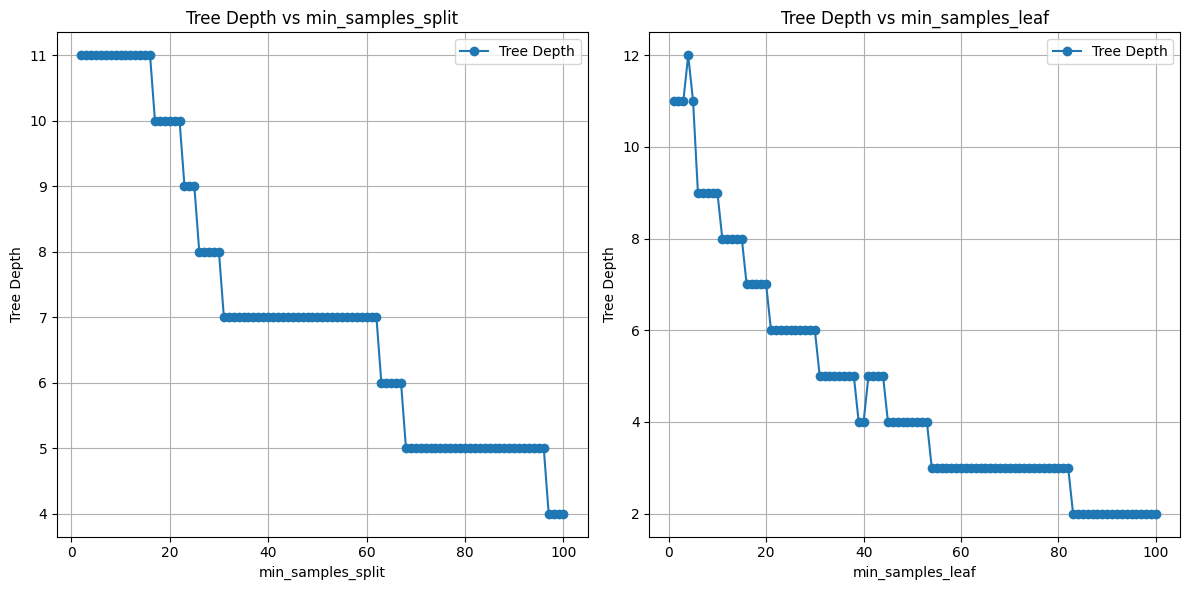

In [48]:
plot_depth_vs_hyperparams(DecisionTreeClassifier)

Leaf hyperparam:: 100%|██████████| 100/100 [00:11<00:00,  8.83it/s]


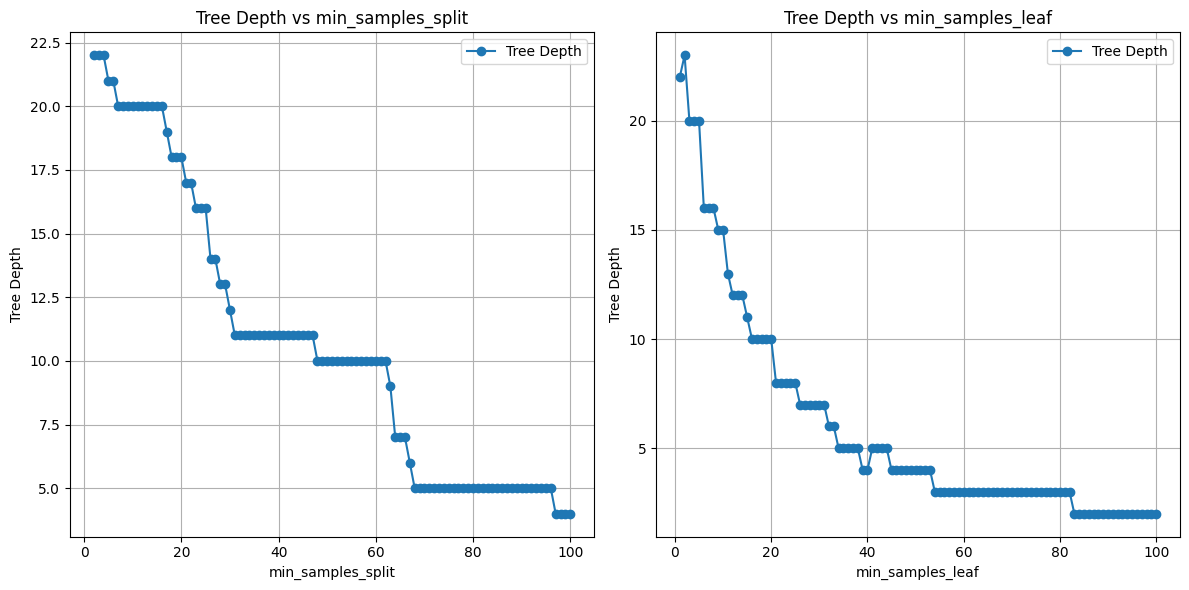

In [51]:
plot_depth_vs_hyperparams(DecisionTree)

In [7]:
def plot_accuracy_vs_depth(tree_model, max_depth, title, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    depths = range(1, max_depth + 1)

    train_errors = []
    test_errors = []

    for depth in tqdm(depths, "Depth:"):
        tree = tree_model(max_depth=depth)
        tree.fit(X_train, y_train)
        y_train_pred = tree.predict(X_train)
        y_test_pred = tree.predict(X_test)
        train_errors.append(accuracy_score(y_train, y_train_pred))
        test_errors.append(accuracy_score(y_test, y_test_pred))

    plt.figure(figsize=(10, 6))
    
    plt.plot(depths, train_errors, label='Train Accuracy', marker='o')
    plt.plot(depths, test_errors, label='Test Accuracy', marker='o')

    plt.xlabel('Tree Depth')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Tree Depth for ' + title)
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.show()


Depth:: 100%|██████████| 25/25 [00:00<00:00, 156.90it/s]


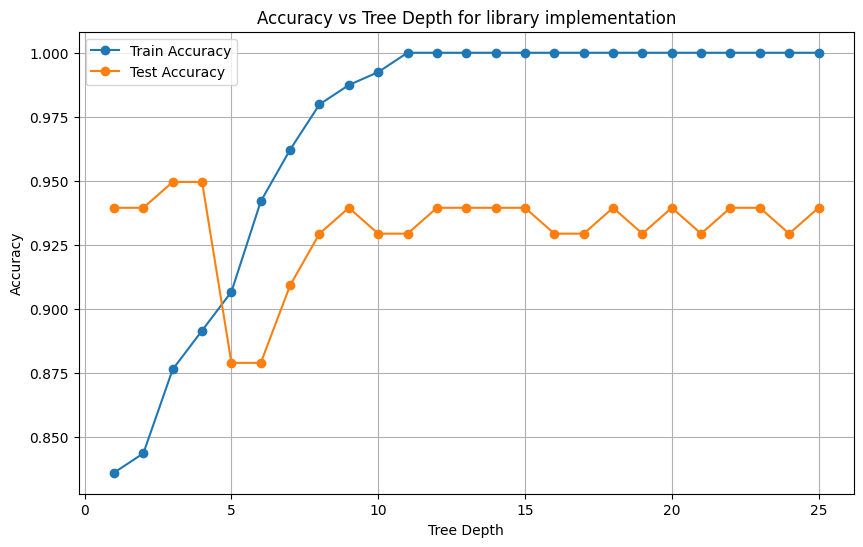

In [56]:
plot_accuracy_vs_depth(DecisionTreeClassifier, 25, "library implementation")

Depth:: 100%|██████████| 25/25 [00:10<00:00,  2.30it/s]


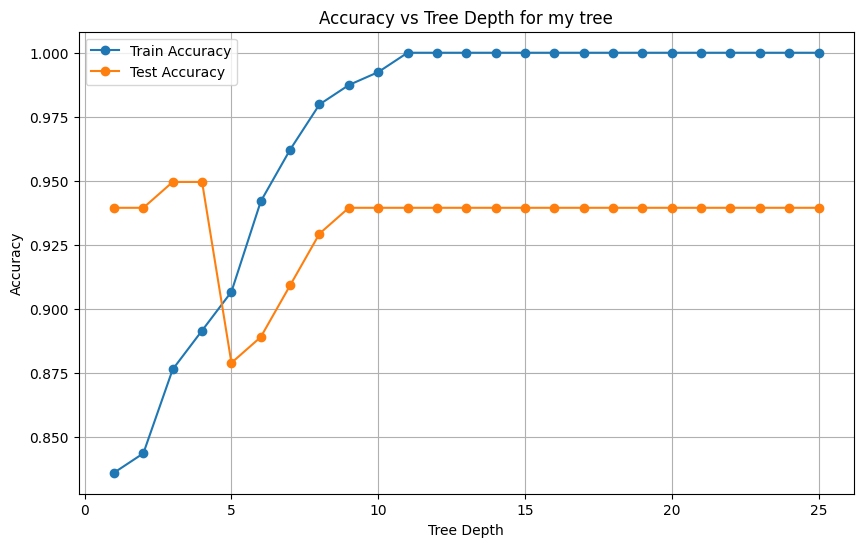

In [57]:
plot_accuracy_vs_depth(DecisionTree, 25, "my tree")

In [8]:
def plot_accuracy_vs_tree_number(forest_model, tree_number, title, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    trees = range(1, tree_number + 1)

    train_errors = []
    test_errors = []

    for n in tqdm(trees, "Tree number:"):
        forest = forest_model(n_estimators=n)
        forest.fit(X_train, y_train)
        y_train_pred = forest.predict(X_train)
        y_test_pred = forest.predict(X_test)
        train_errors.append(accuracy_score(y_train, y_train_pred))
        test_errors.append(accuracy_score(y_test, y_test_pred))

    plt.figure(figsize=(10, 6))
    
    plt.plot(trees, train_errors, label='Train Accuracy', marker='o')
    plt.plot(trees, test_errors, label='Test Accuracy', marker='o')

    plt.xlabel('Tree Depth')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Tree Number for ' + title)
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.show()

Tree number:: 100%|██████████| 100/100 [32:15<00:00, 19.36s/it]


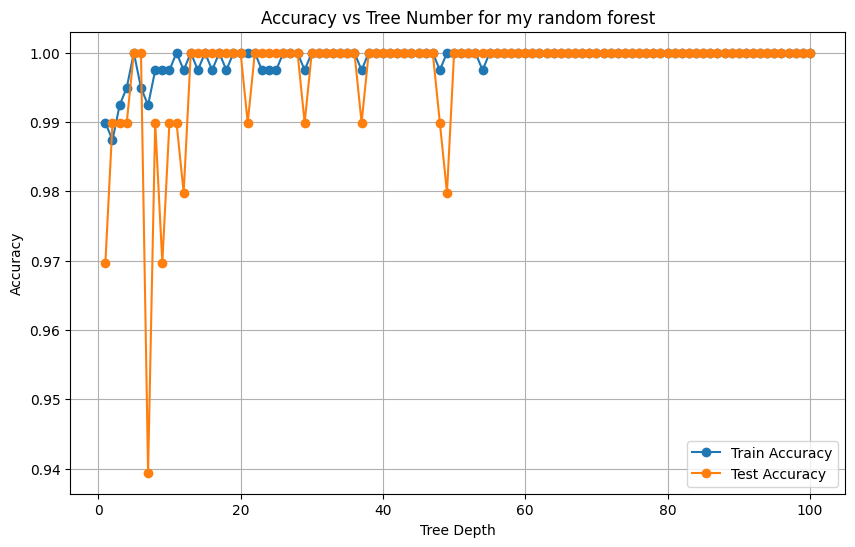

In [59]:
plot_accuracy_vs_tree_number(RandomForest, 100, "my random forest")

Tree number:: 100%|██████████| 500/500 [04:38<00:00,  1.80it/s]


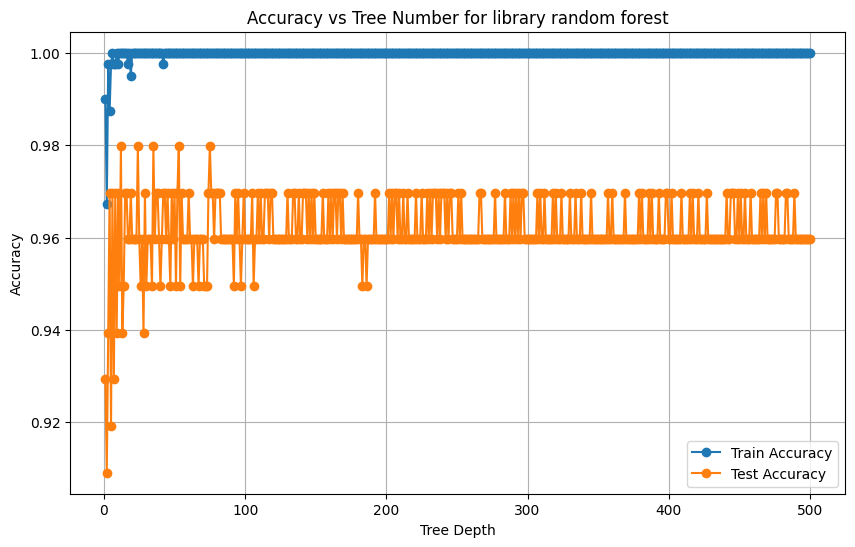

In [11]:
plot_accuracy_vs_tree_number(RandomForestClassifier, 500, "library random forest")

In [36]:
tree = DecisionTree(max_depth=5, criterion='entropy')
tree.fit(X_train, y_train)
print("Decision Tree Accuracy:", np.sum(tree.predict(X_test) == y_test) / len(X_test))

forest = RandomForest(max_depth=5, n_estimators=10, criterion='entropy')
forest.fit(X_train, y_train)
print("Random Forest Accuracy:", np.sum(forest.predict(X_test) == y_test) / len(X_test))

gb = GradientBoosting(base_learner=lambda: DecisionTree(max_depth=5, criterion='entropy'), T=50,
                      loss_function=QuadraticLoss,
                      learning_rate=0.1)
gb.fit(X_train, y_train)
print("Gradient boosting:", np.sum(gb.predict(X_test) == y_test) / len(X_test))

Decision Tree Accuracy: 0.9797979797979798
Random Forest Accuracy: 0.9696969696969697


100%|██████████| 50/50 [00:29<00:00,  1.71it/s]

Gradient boosting: 0.7373737373737373
